In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df= pd.read_csv("train.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


### cleaning

In [5]:
df.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [6]:
df.shape

(53043, 3)

In [7]:
# Removing the unnecessary column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.rename(columns={
        'statement': 'Statement',
        'status': 'Mental Health Status'
    })

In [8]:
#drop rows woth missong statement (362)
df = df.dropna(subset=['Statement'])
def clean_text(text):
        # Remove URLs and markdown links
        text = re.sub(r'http\S+|www\S+|\[.*?\]\(.*?\)', '', text, flags=re.IGNORECASE)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text, flags=re.IGNORECASE)
        # Remove handles
        text = re.sub(r'@\w+', '', text)
        # Remove punctuation and special characters (keep letters and whitespace)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Remove newline characters
        text = re.sub(r'[\r\n]+', ' ', text)
        # Remove words containing numbers
        text = re.sub(r'\w*\d\w*', '', text)
        # Remove extra spaces and trim
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
df['Statement'] = df['Statement'].apply(clean_text)
# Convert to lowercase and strip whitespace
df['Mental Health Status'] = df['Mental Health Status'].str.lower().str.strip()

In [9]:
df['Mental Health Status'].unique()

array(['anxiety', 'normal', 'depression', 'suicidal', 'stress', 'bipolar',
       'personality disorder'], dtype=object)

In [10]:
valid_statuses = {
        'anxiety', 'normal', 'depression', 'suicidal', 'stress', 'bipolar',
       'personality disorder'}
# Handle invalid statuses
invalid_status = ~df['Mental Health Status'].isin(valid_statuses)
if invalid_status.sum() > 0:
    print(f"Found {invalid_status.sum()} rows with invalid mental health status")
    df = df[~invalid_status]

In [11]:
# Check for duplicates in the "Statement" column
print(f"Number of duplicates: {df.duplicated(subset=['Statement']).sum()}")
df = df.drop_duplicates(subset=['Statement'], keep='first')

Number of duplicates: 1744


In [12]:
df = df.reset_index(drop=True)
if 'unique_id' not in df.columns:
        df.insert(0, 'unique_id', range(1, 1 + len(df)))

In [13]:
# Final validation
print(" Cleaning report:")
print(f"Final dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")
print("\nMental Health Status distribution:")
print(df['Mental Health Status'].value_counts())

 Cleaning report:
Final dataset shape: (50937, 3)
Missing values:
unique_id               0
Statement               0
Mental Health Status    0
dtype: int64

Mental Health Status distribution:
Mental Health Status
normal                  15945
depression              15078
suicidal                10627
anxiety                  3607
bipolar                  2500
stress                   2288
personality disorder      892
Name: count, dtype: int64


### Exploratory Data Analysis 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


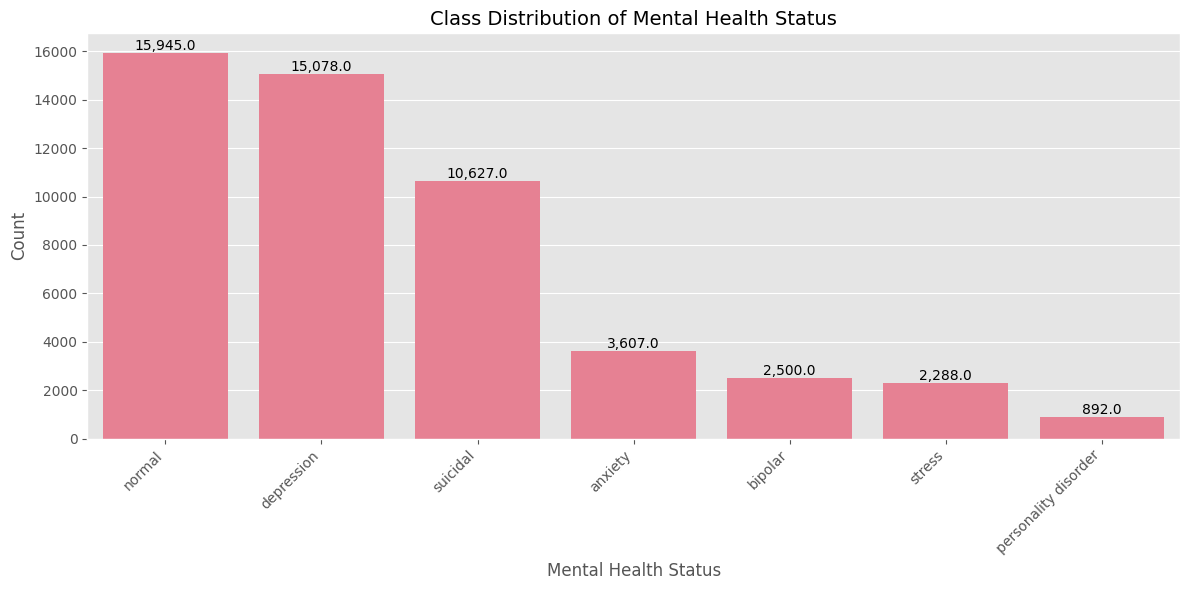

In [22]:
from wordcloud import WordCloud
from collections import defaultdict
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Customize plot styles
plt.style.use('ggplot')
sns.set_palette("husl")

# 1. Class Distribution Analysis
plt.figure(figsize=(12,6))
status_counts = df['Mental Health Status'].value_counts()
ax = sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Class Distribution of Mental Health Status', fontsize=14)
plt.xlabel('Mental Health Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0,5), textcoords='offset points')
plt.tight_layout()
plt.show()

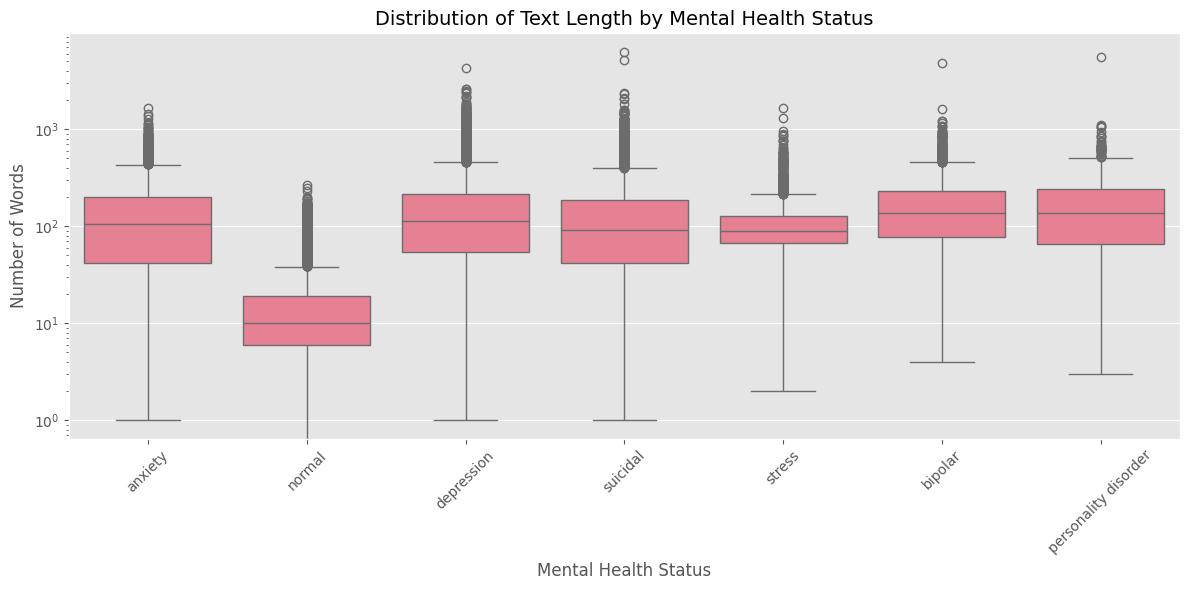

In [23]:
# 2. Text Length Analysis
df['text_length'] = df['Statement'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.boxplot(x='Mental Health Status', y='text_length', data=df)
plt.title('Distribution of Text Length by Mental Health Status', fontsize=14)
plt.xlabel('Mental Health Status', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')  # Using log scale due to outliers
plt.tight_layout()
plt.show()

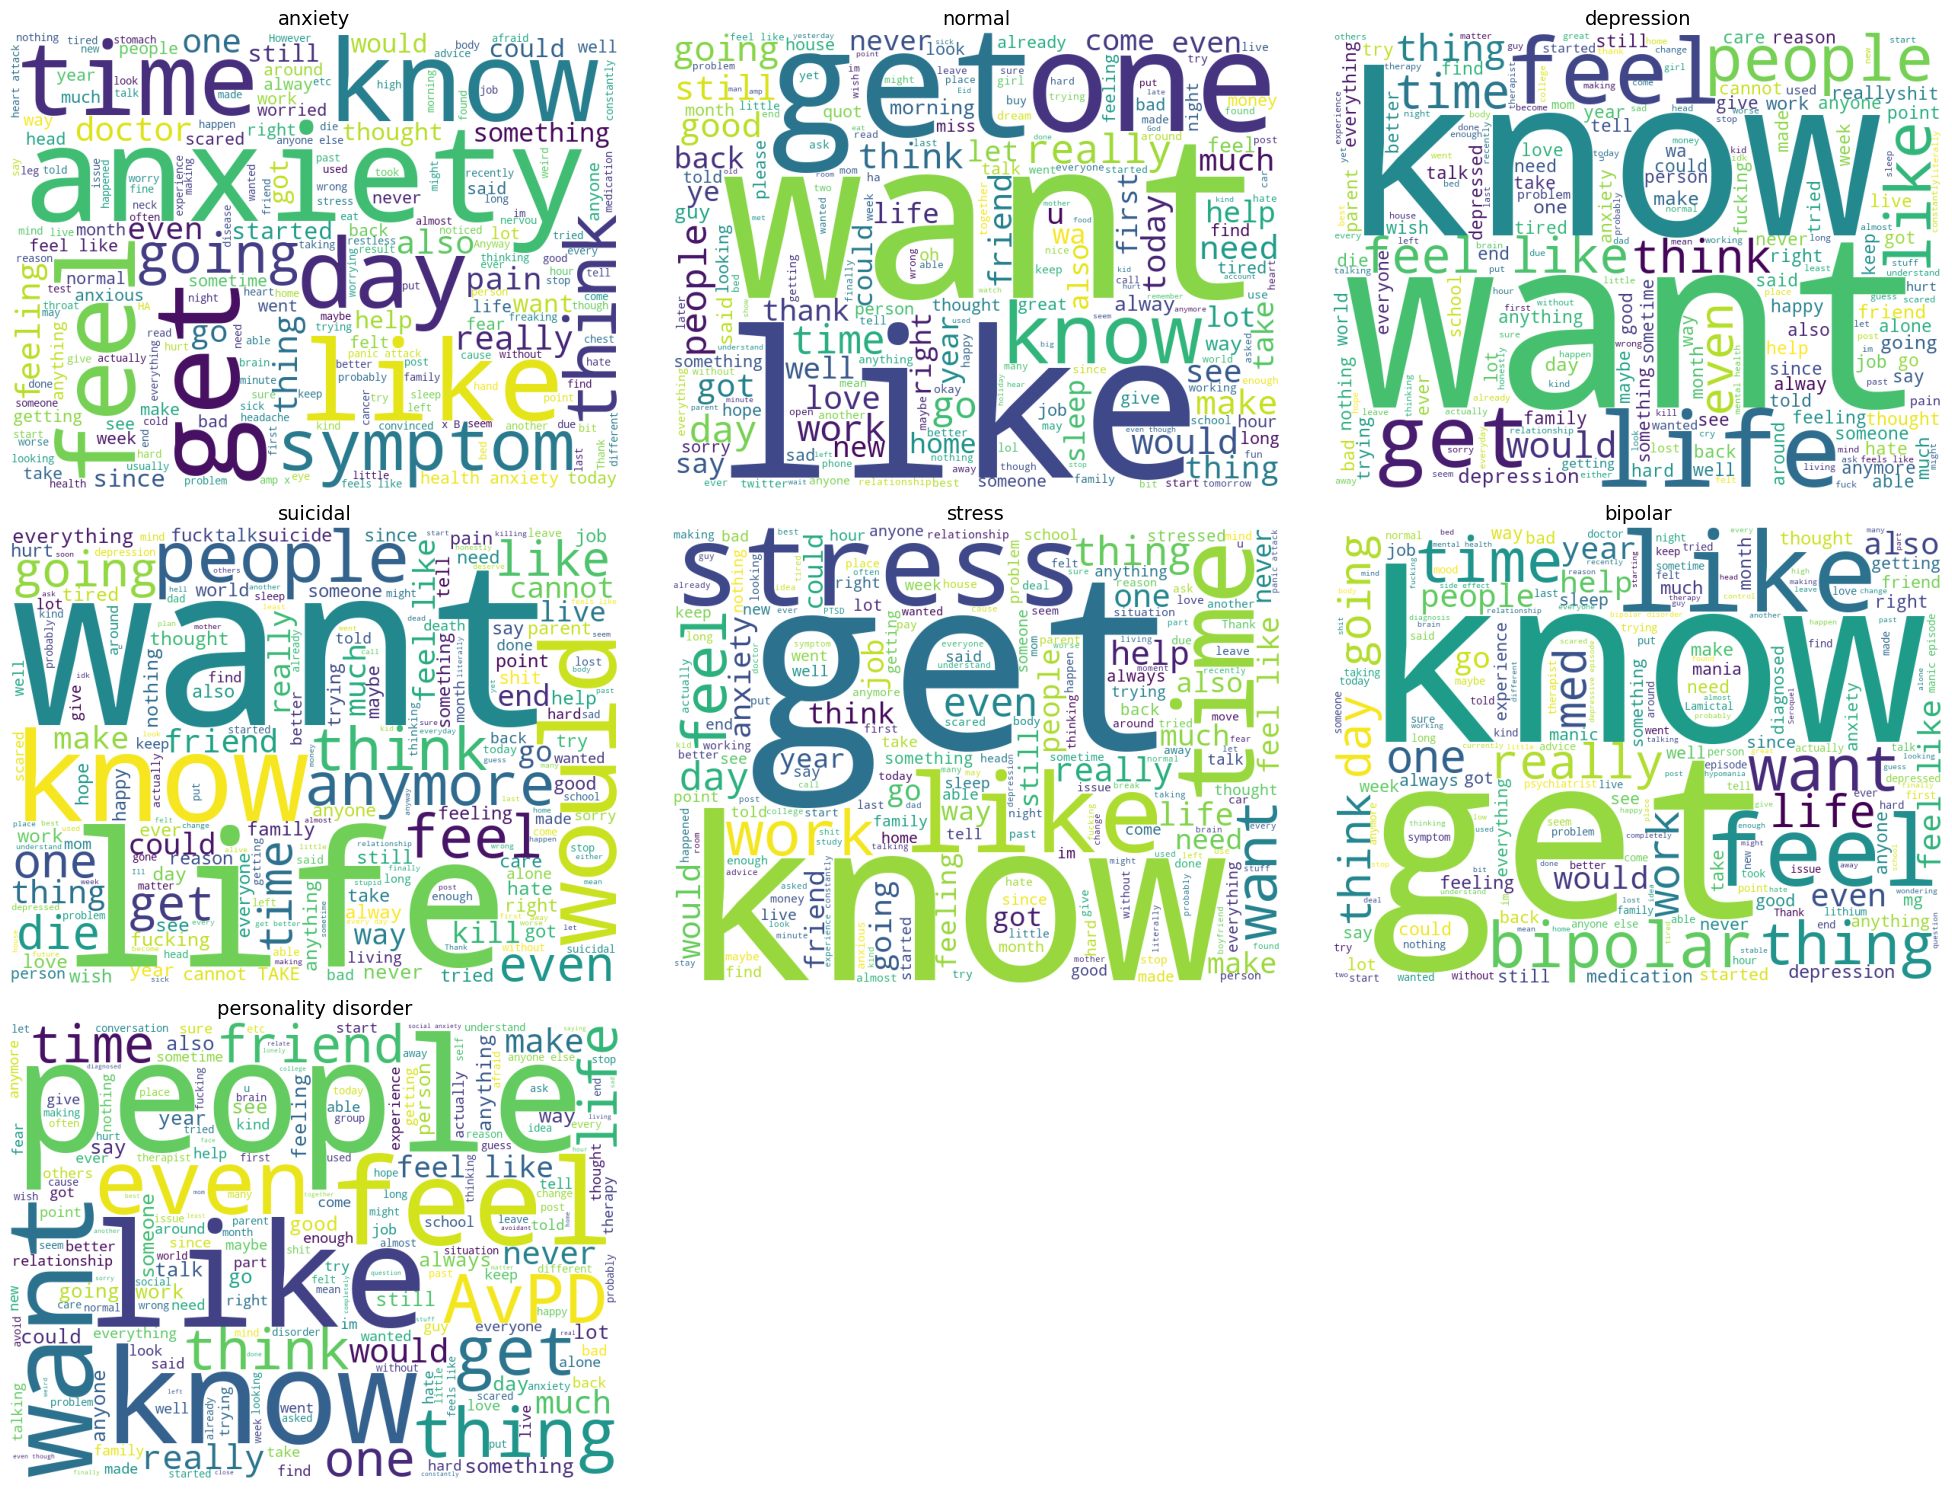

In [24]:
# 3. Word Cloud Generation
def generate_wordclouds(statuses):
    plt.figure(figsize=(20, 15))
    for i, status in enumerate(statuses, 1):
        plt.subplot(3, 3, i)
        text = ' '.join(df[df['Mental Health Status'] == status]['Statement'])
        wordcloud = WordCloud(width=800, height=600, 
                             background_color='white',
                             stopwords=stop_words,
                             max_words=200,
                             colormap='viridis').generate(text)
        plt.imshow(wordcloud)
        plt.title(status, fontsize=14)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_wordclouds(df['Mental Health Status'].unique())

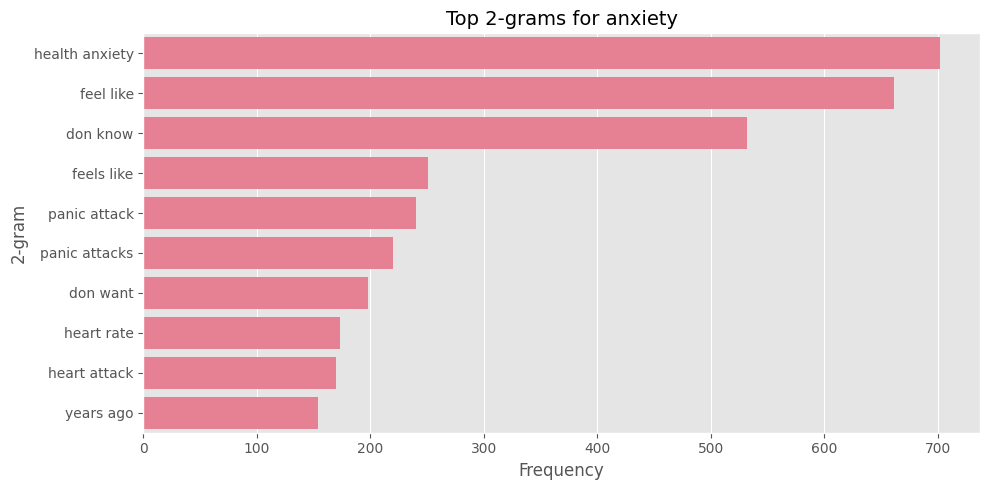

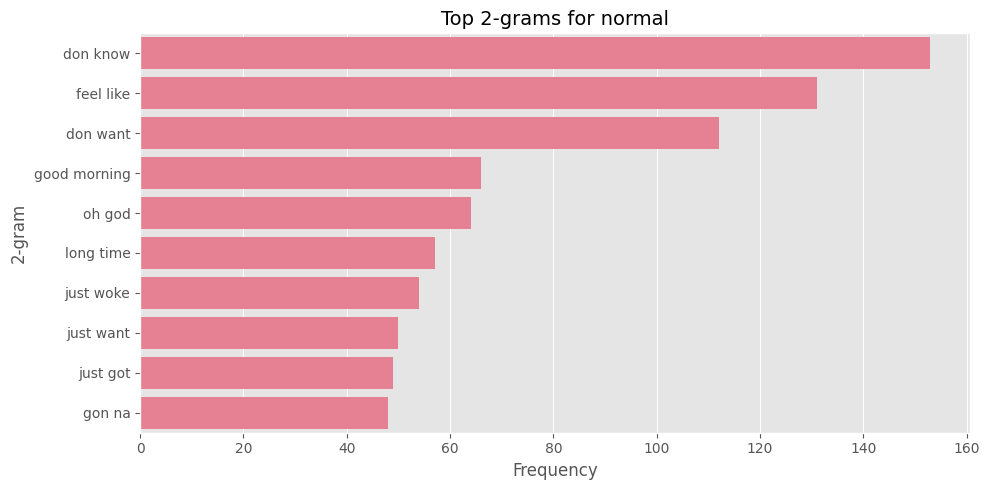

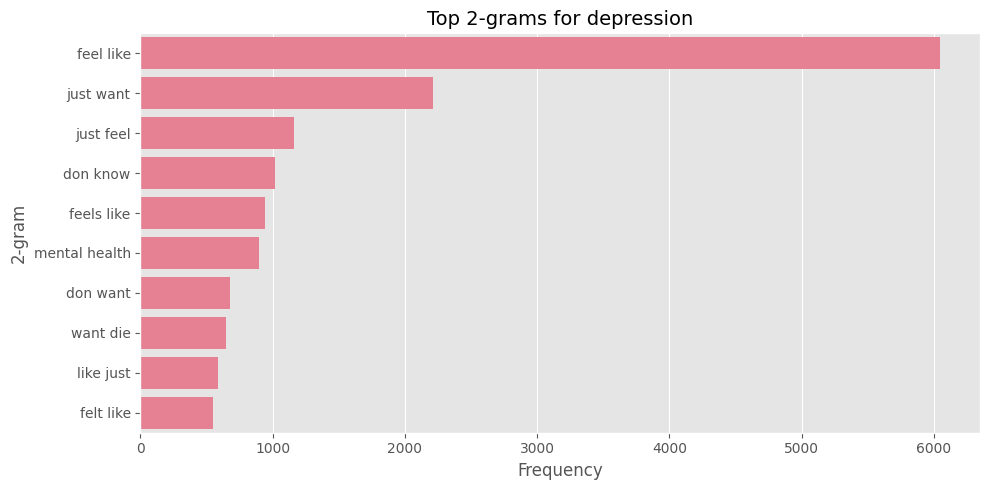

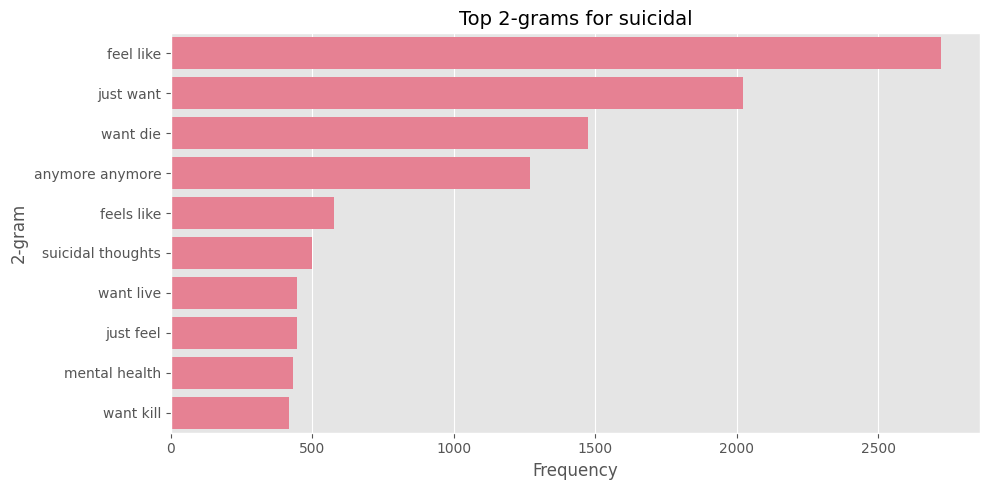

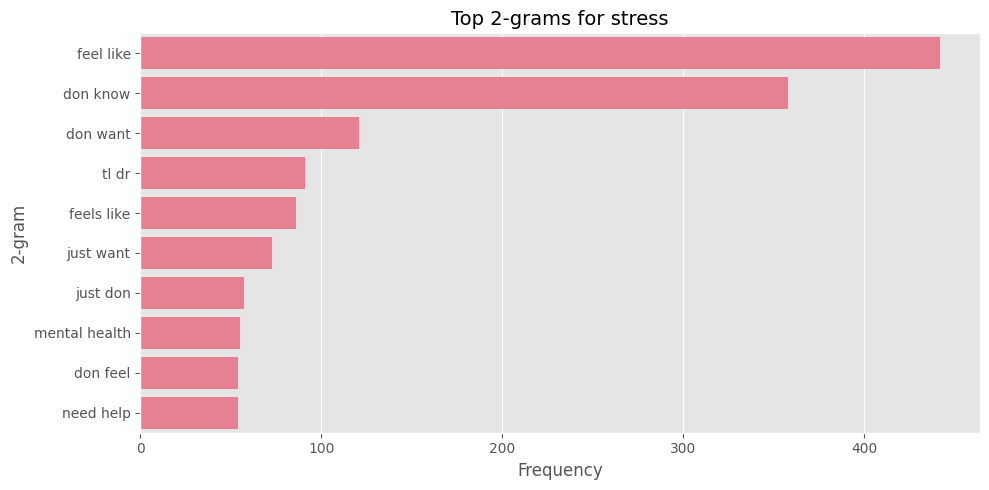

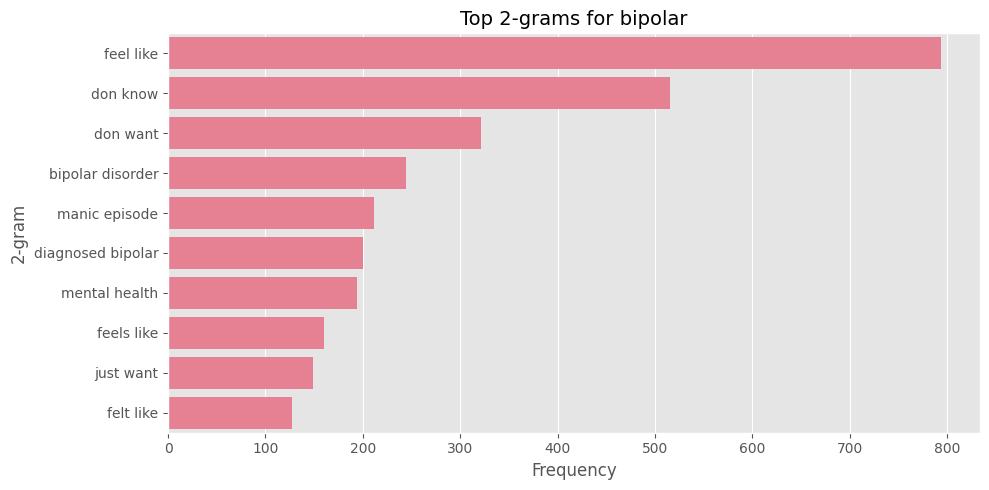

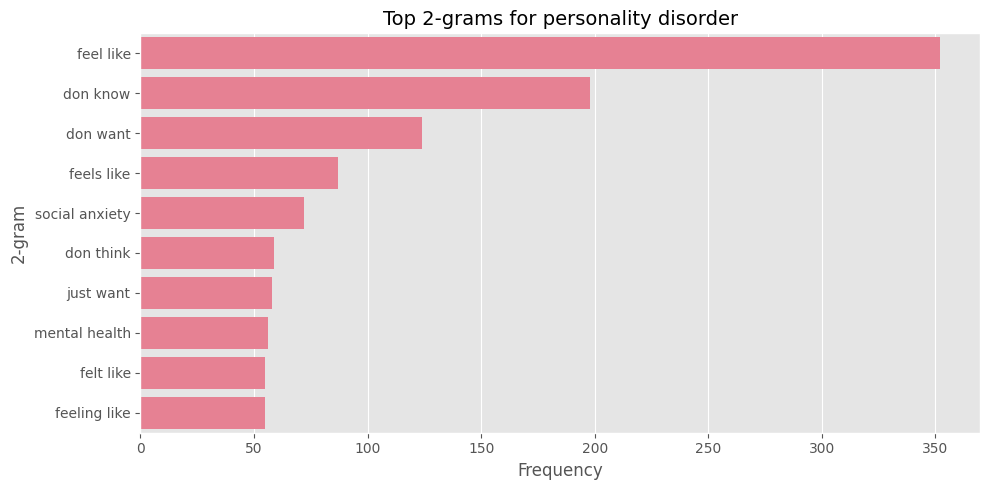

In [25]:
# 4. Top N-grams Analysis
def plot_top_ngrams(status, n=2, top_k=10):
    text = ' '.join(df[df['Mental Health Status'] == status]['Statement'])
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit([text])  # Changed here
    bag_of_words = vec.transform([text])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=[val[1] for val in words_freq], y=[val[0] for val in words_freq])
    plt.title(f'Top {n}-grams for {status}', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(f'{n}-gram', fontsize=12)
    plt.tight_layout()
    plt.show()
for status in df['Mental Health Status'].unique():
    plot_top_ngrams(status, n=2)  # Change n=3 for trigrams

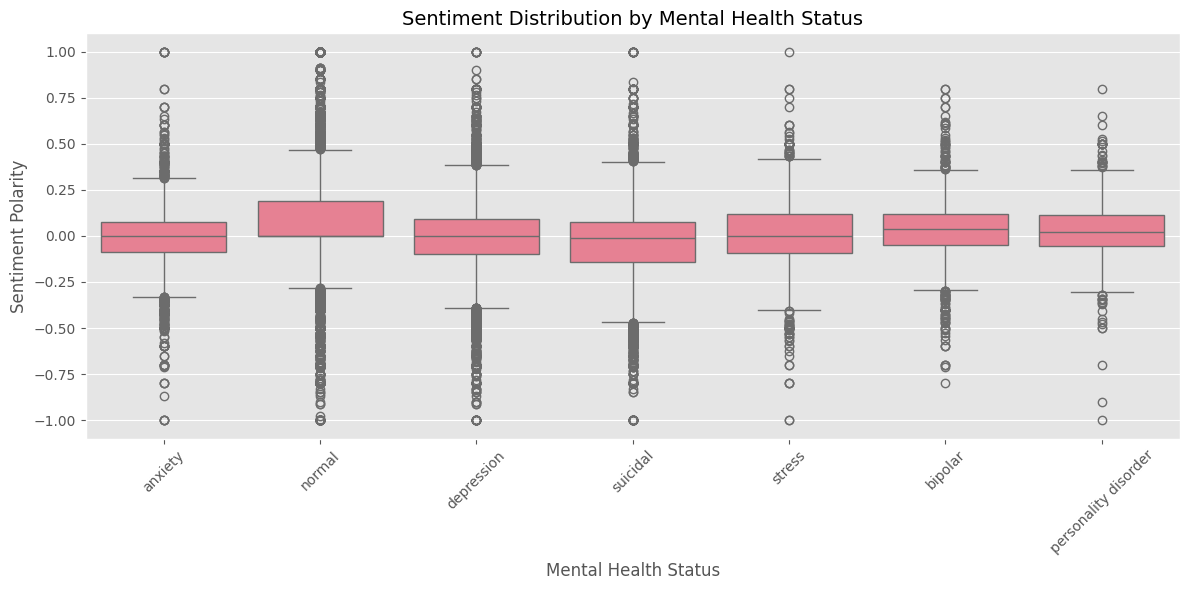

In [26]:
# 5. Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['Statement'].apply(get_sentiment)

plt.figure(figsize=(12,6))
sns.boxplot(x='Mental Health Status', y='sentiment', data=df)
plt.title('Sentiment Distribution by Mental Health Status', fontsize=14)
plt.xlabel('Mental Health Status', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

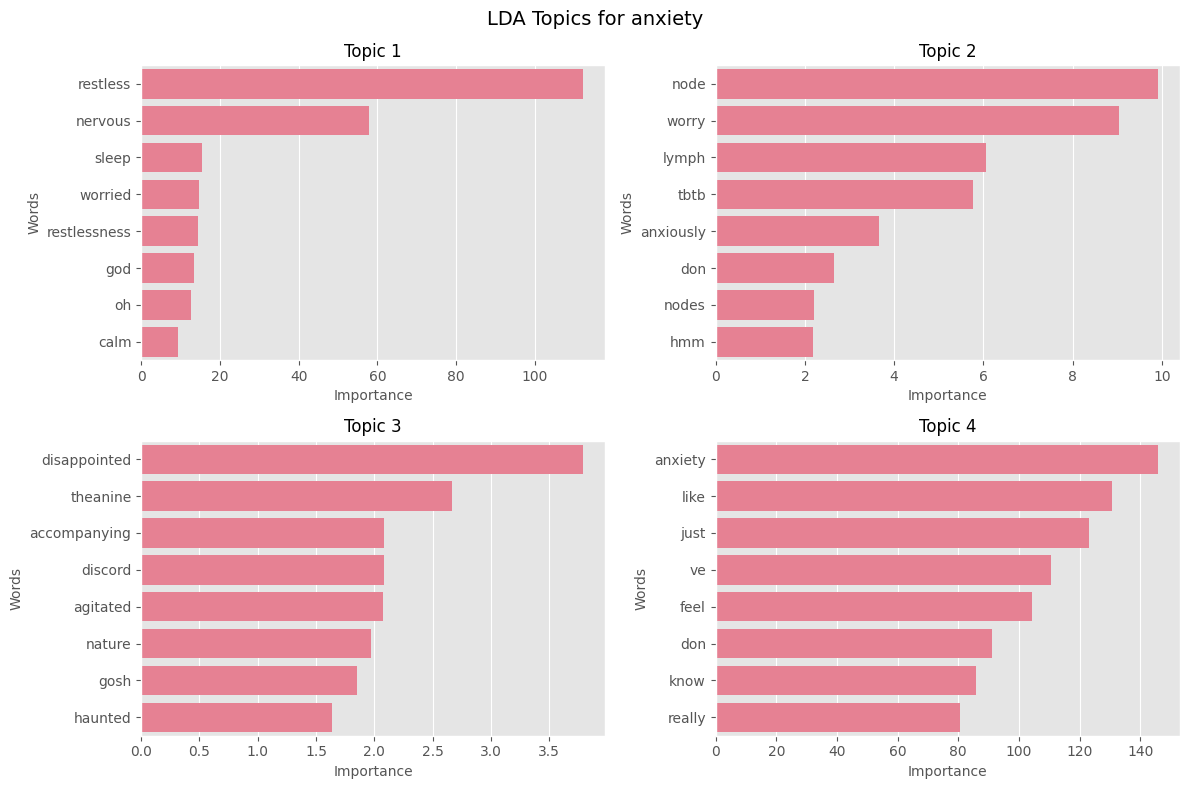

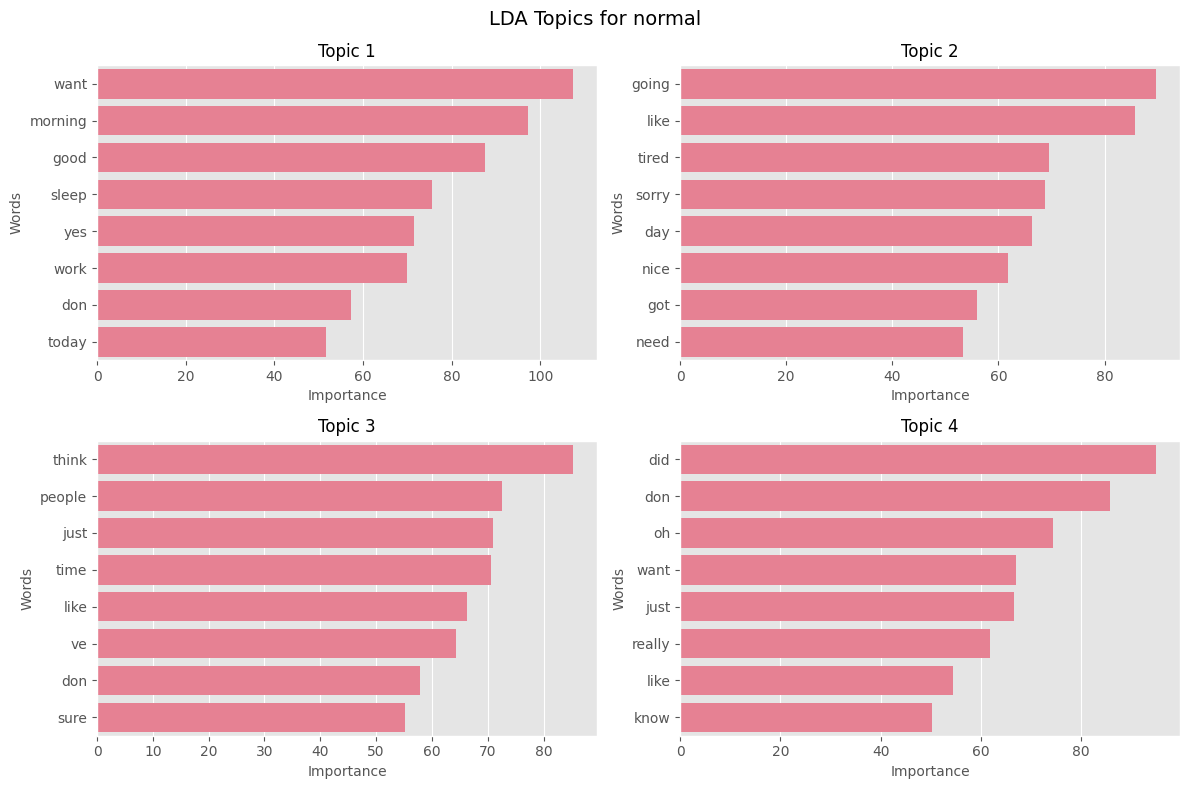

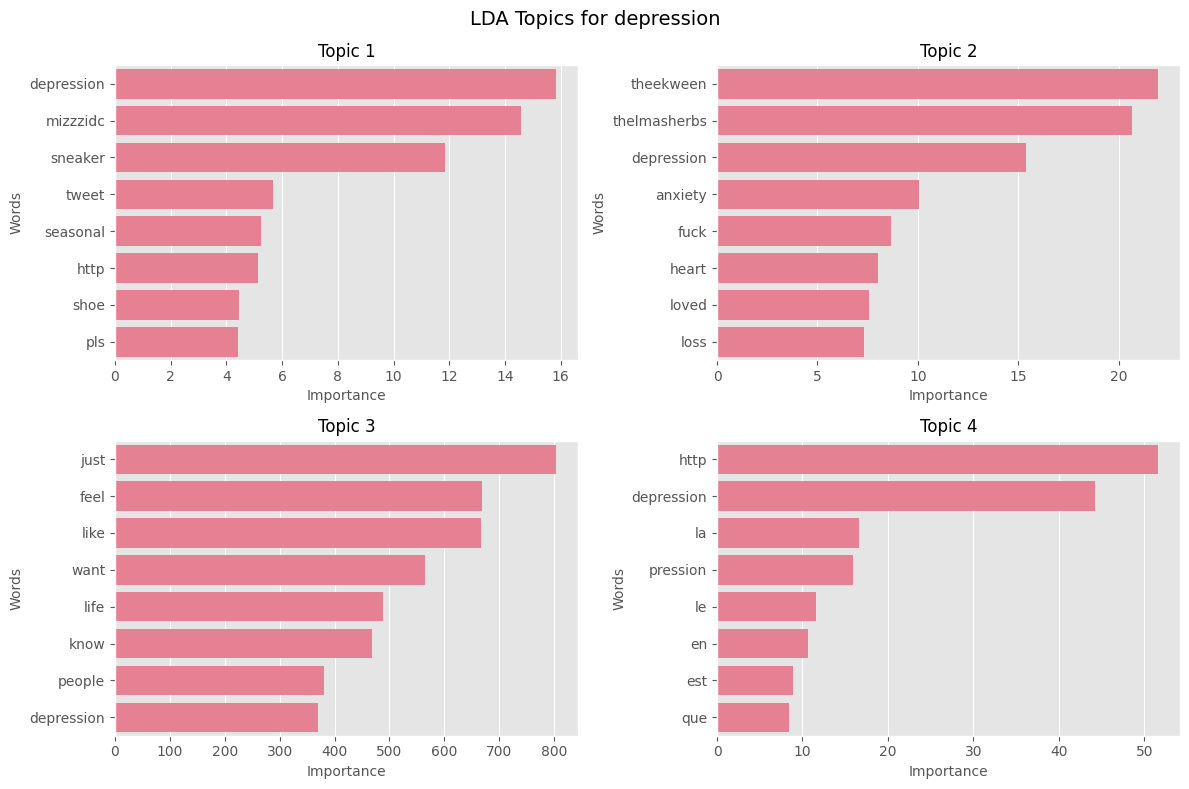

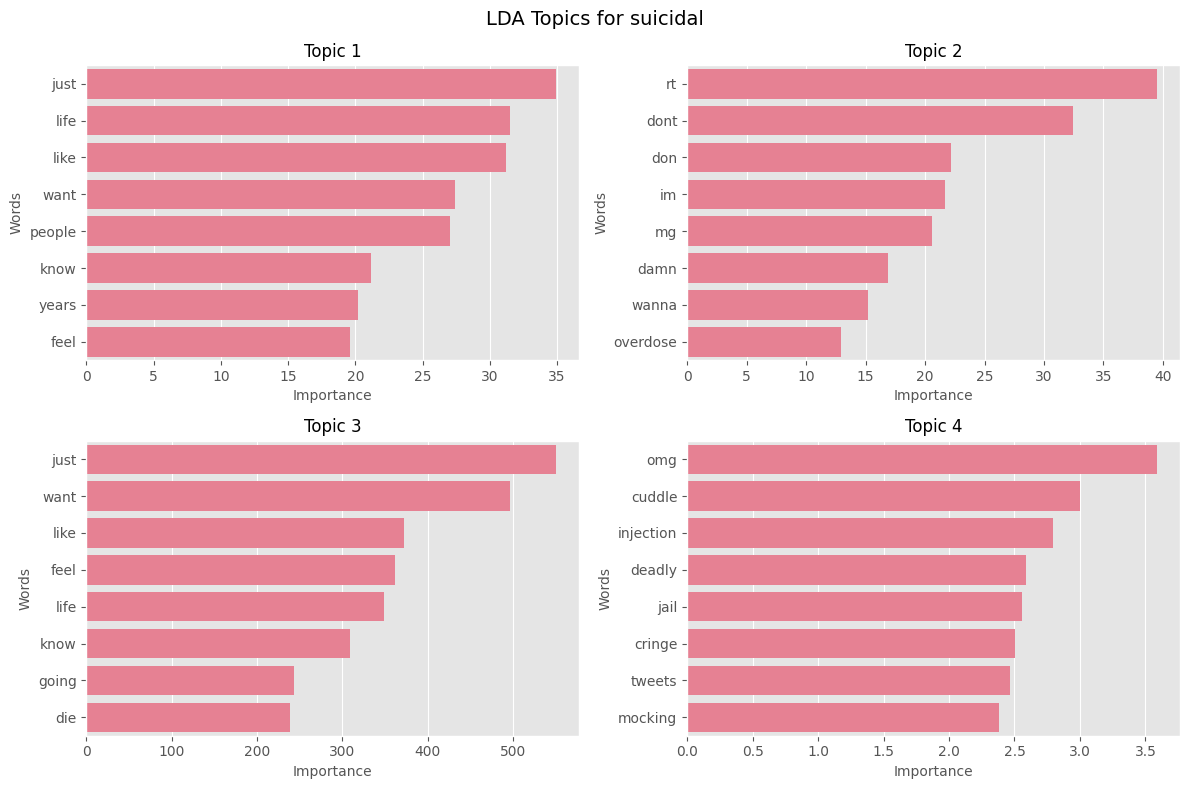

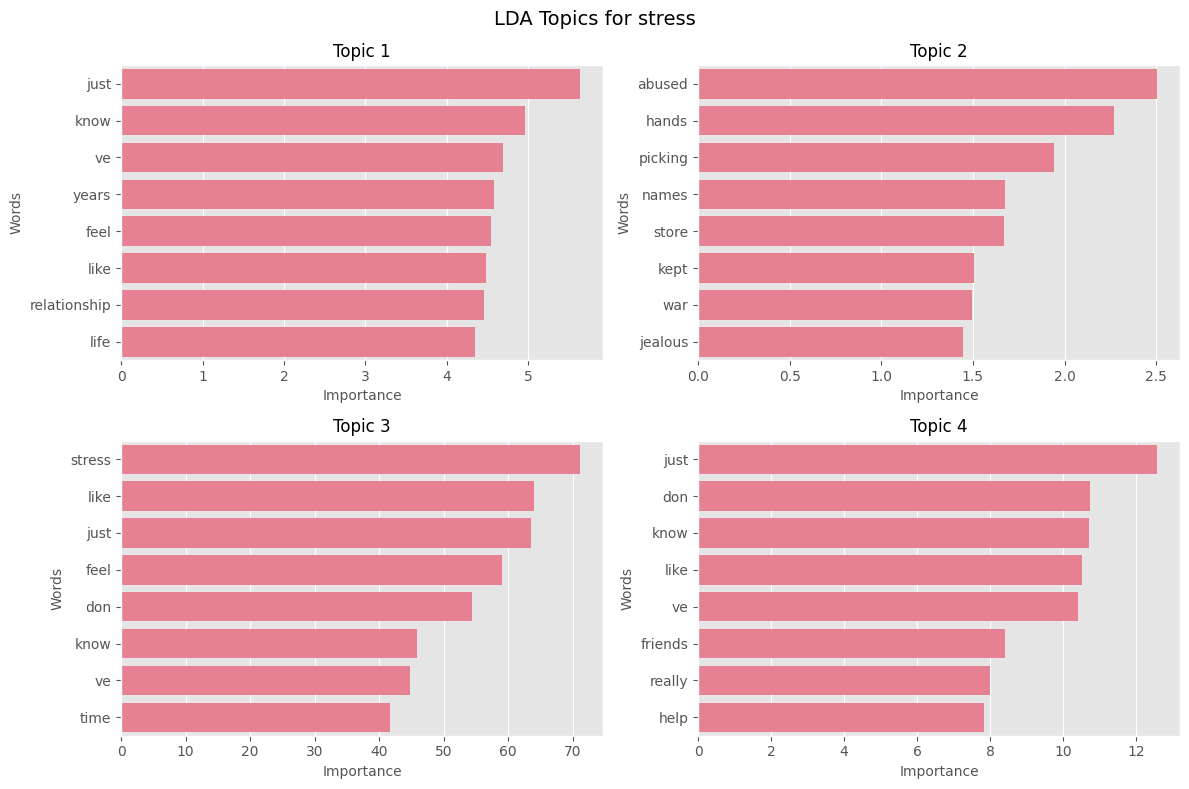

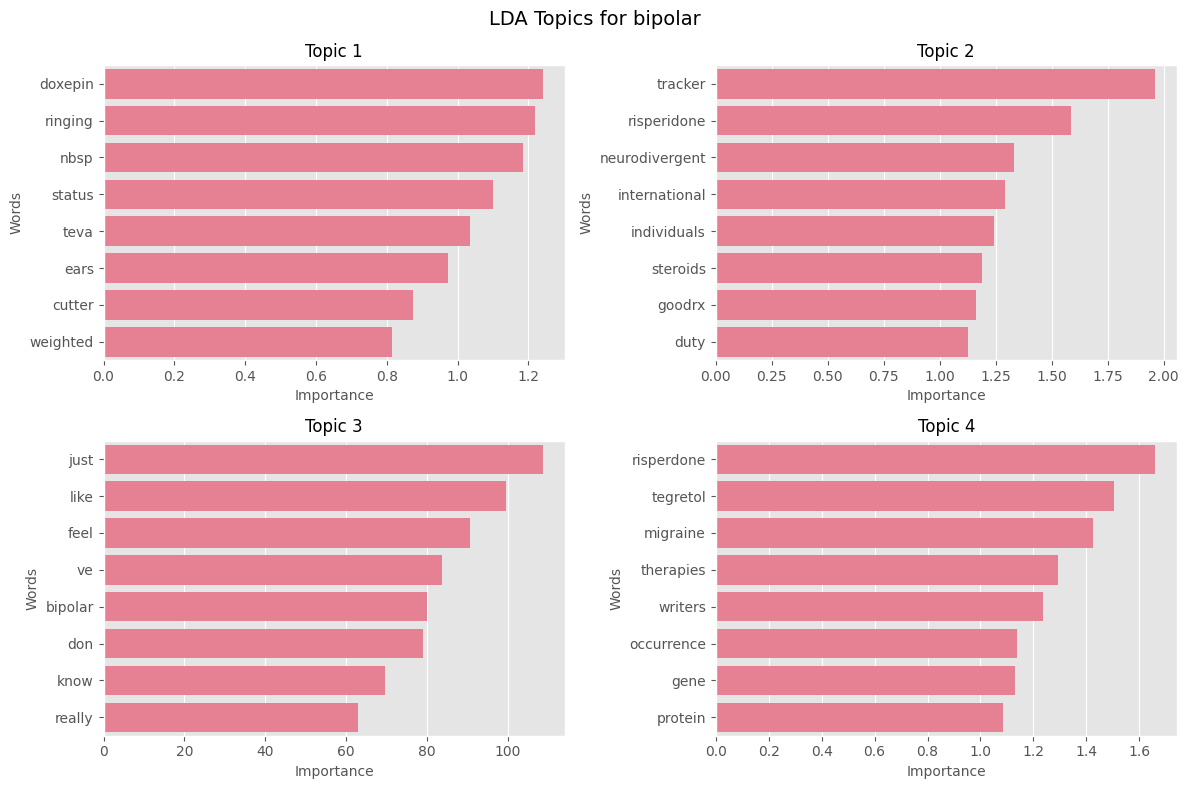

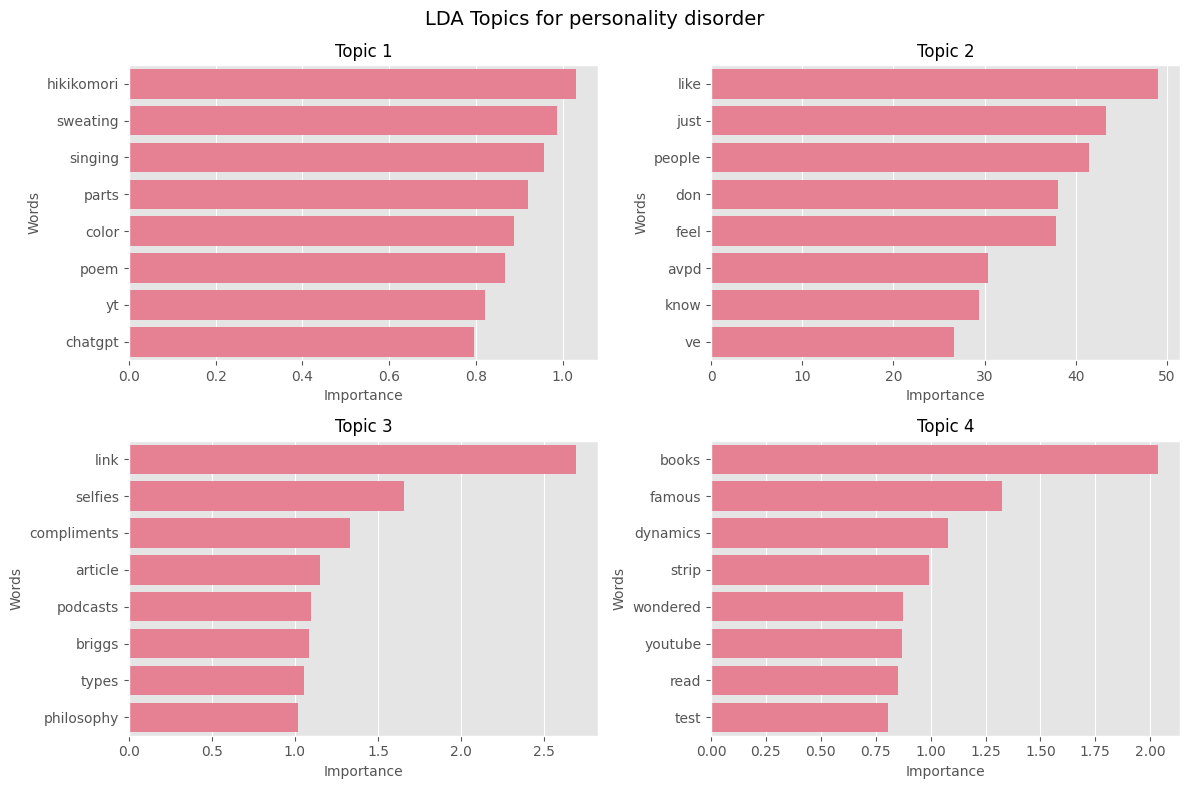

In [27]:
# 6. Topic Modeling Visualization (LDA)
def plot_lda_topics(status, n_top_words=8):
    text = df[df['Mental Health Status'] == status]['Statement']
    tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tf = tf_vectorizer.fit_transform(text)
    
    lda = LatentDirichletAllocation(n_components=4, random_state=42)
    lda.fit(tf)
    
    tf_feature_names = tf_vectorizer.get_feature_names_out()
    
    plt.figure(figsize=(12,8))
    for topic_idx, topic in enumerate(lda.components_):
        top_features = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        plt.subplot(2, 2, topic_idx+1)
        sns.barplot(x=np.sort(topic)[::-1][:n_top_words], y=top_features)
        plt.title(f'Topic {topic_idx+1}', fontsize=12)
        plt.xlabel('Importance', fontsize=10)
        plt.ylabel('Words', fontsize=10)
    plt.suptitle(f'LDA Topics for {status}', fontsize=14)
    plt.tight_layout()
    plt.show()

for status in df['Mental Health Status'].unique():  # Limit to first 3 for demo
    plot_lda_topics(status)

In [28]:
# 7. Correlation Between Text Features and Mental Health Status
# This could involve more advanced NLP techniques and machine learning

print("\nAdditional Statistics:")
print(f"Average text length: {df['text_length'].mean():.1f} words")
print(f"Median text length: {df['text_length'].median()} words")
print(f"Most common status: {status_counts.idxmax()} ({status_counts.max()} entries)")
print(f"Least common status: {status_counts.idxmin()} ({status_counts.min()} entries)")


Additional Statistics:
Average text length: 114.0 words
Median text length: 62.0 words
Most common status: normal (15945 entries)
Least common status: personality disorder (892 entries)


### text preprocessing

In [29]:
# Tokenization function
def tokenize(text):
    return word_tokenize(text)
df['Tokenized Statement'] = df['Statement'].apply(tokenize)
print(df[['Statement', 'Tokenized Statement']].head())

                                           Statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  All wrong back off dear forward doubt Stay in ...   
3  I ve shifted my focus to something else but I ...   
4  I m restless and restless it s been a month no...   

                                 Tokenized Statement  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [All, wrong, back, off, dear, forward, doubt, ...  
3  [I, ve, shifted, my, focus, to, something, els...  
4  [I, m, restless, and, restless, it, s, been, a...  


In [30]:
# Normalization
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text_tokens):
    return [word.lower() for word in text_tokens if word.lower() not in stop_words]
df['Normalized Statement'] = df['Tokenized Statement'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df['Label'] = df['Mental Health Status']

### Extract Features

In [27]:
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cpu
None


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [29]:
from tqdm import tqdm
BATCH_SIZE = 8  # Reduced for RX5500M's 4GB VRAM
MAX_LENGTH = 128  # Reduced sequence length
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model with memory optimizations
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True).to(DEVICE)
model = model.eval()

def generate_bert_embeddings(texts):
    embeddings = []
    
    # Process in batches
    for i in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch = texts[i:i+BATCH_SIZE]
        
        # Tokenize with AMD-optimized settings
        tokens = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        ).to(DEVICE)
        
        # Disable gradient calculation
        with torch.no_grad():
            outputs = model(**tokens)
            
        # Use mean pooling instead of [CLS] token
        hidden_states = outputs.hidden_states[-2]
        batch_embeddings = torch.mean(hidden_states, dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    
    return embeddings

# Generate embeddings with memory monitoring
print("Generating BERT embeddings...")
df['BERT_Embedding'] = generate_bert_embeddings(df['Statement'].tolist())

# Verify embeddings
print("Embedding shape sample:", df['BERT_Embedding'].iloc[0].shape)

Generating BERT embeddings...


100%|██████████| 6368/6368 [1:01:13<00:00,  1.73it/s]

Embedding shape sample: (768,)


In [30]:
# Convert BERT embeddings to numpy array
X_bert = np.array(df['BERT_Embedding'].tolist())
y = df['Label']

In [31]:
# Encode labels
le = LabelEncoder()
y_encoded= le.fit_transform(df['Label'])

In [32]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


In [33]:
# Data augmentation for minority classes
minority_classes = ['personality disorder', 'stress']
for cls in minority_classes:
    cls_idx = le.transform([cls])[0]
    mask = (y_encoded == cls_idx)
    num_samples = sum(mask)
    # Duplicate minority samples
    duplicated_indices = np.random.choice(np.where(mask)[0], size=num_samples, replace=True)
    X_bert = np.vstack([X_bert, X_bert[duplicated_indices]])
    y_encoded = np.concatenate([y_encoded, y_encoded[duplicated_indices]])
    


In [58]:
# Split dataset using BERT embeddings
X_train, X_test, y_train, y_test = train_test_split(
        X_bert, y_encoded,
        test_size=0.2,
        random_state=45,
        stratify=y_encoded
    )
    

    # Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Define classifier model using BERT embeddings
class BERTEmbeddingClassifier(nn.Module):
        def __init__(self, input_dim, num_classes):
            super(BERTEmbeddingClassifier, self).__init__()
            self.classifier = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
        
        def forward(self, x):
            return self.classifier(x)

    # Initialize model
input_dim = X_bert.shape[1]  # Should be 768 for BERT-base
model = BERTEmbeddingClassifier(input_dim, len(le.classes_)).to(DEVICE)

    # Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    # Training loop
NUM_EPOCHS = 70
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_acc = correct / total
        scheduler.step(epoch_acc)

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_bert_embedding_model.pth')

        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print(f'Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        print('-' * 50)

# Load best model
model.load_state_dict(torch.load('best_bert_embedding_model.pth'))

# Final evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Epoch 1/70
Loss: 1.1003 | Acc: 0.6672
--------------------------------------------------
Epoch 2/70
Loss: 0.8414 | Acc: 0.6942
--------------------------------------------------
Epoch 3/70
Loss: 0.7681 | Acc: 0.7152
--------------------------------------------------
Epoch 4/70
Loss: 0.7252 | Acc: 0.7244
--------------------------------------------------
Epoch 5/70
Loss: 0.6934 | Acc: 0.7267
--------------------------------------------------
Epoch 6/70
Loss: 0.6664 | Acc: 0.7336
--------------------------------------------------
Epoch 7/70
Loss: 0.6438 | Acc: 0.7413
--------------------------------------------------
Epoch 8/70
Loss: 0.6219 | Acc: 0.7452
--------------------------------------------------
Epoch 9/70
Loss: 0.6031 | Acc: 0.7528
--------------------------------------------------
Epoch 10/70
Loss: 0.5854 | Acc: 0.7498
--------------------------------------------------
Epoch 11/70
Loss: 0.5691 | Acc: 0.7570
--------------------------------------------------
Epoch 12/70
Loss: 0

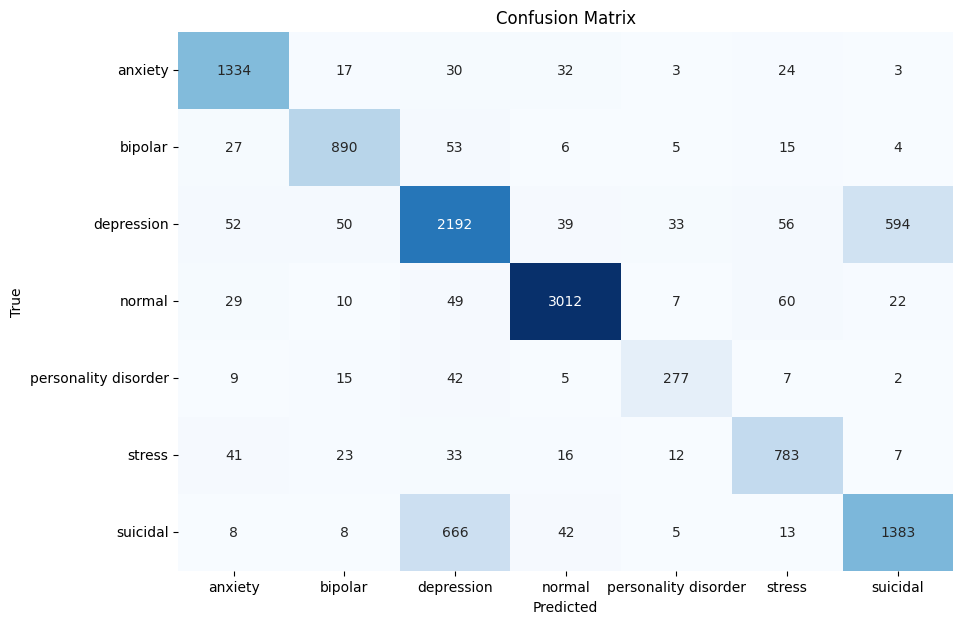

                      precision    recall  f1-score   support

             anxiety       0.89      0.92      0.91      1443
             bipolar       0.88      0.89      0.88      1000
          depression       0.72      0.73      0.72      3016
              normal       0.96      0.94      0.95      3189
personality disorder       0.81      0.78      0.79       357
              stress       0.82      0.86      0.84       915
            suicidal       0.69      0.65      0.67      2125

            accuracy                           0.82     12045
           macro avg       0.82      0.82      0.82     12045
        weighted avg       0.82      0.82      0.82     12045



<Figure size 1200x600 with 0 Axes>

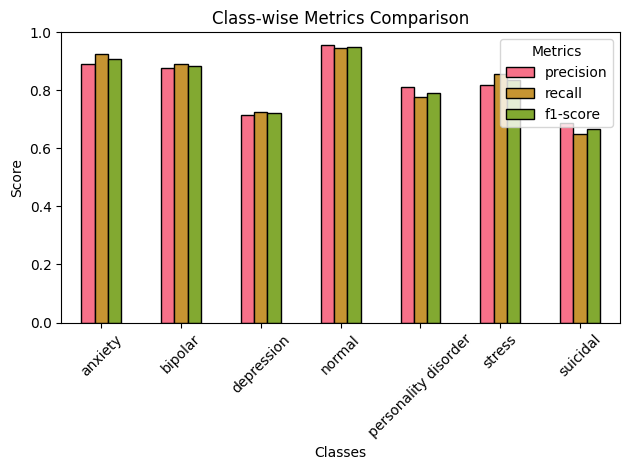

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=le.classes_, output_dict=True)
focus_classes = le.classes_  # Adjust this if you want to focus on specific classes
focus_metrics = pd.DataFrame({cls: report[cls] for cls in focus_classes}).T
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Plotting Class-wise Metrics
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", len(focus_classes))  # Use a color palette
focus_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', color=colors, edgecolor='black')
plt.title('Class-wise Metrics Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Classes')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [60]:
import torch
import joblib  # For saving the label encoder

# Save your best model weights
torch.save(model.state_dict(), 'best_bert_embedding_model_exp3.pth')
print("Model saved as best_bert_embedding_model_exp3.pth")

# Save the label encoder for later usage
joblib.dump(le, 'label_encoder_exp3.pkl')
print("Label encoder saved as label_encoder_exp3.pkl")



Model saved as best_bert_embedding_model_exp3.pth
Label encoder saved as label_encoder_exp3.pkl



Enhanced Classification Report:
                      precision    recall  f1-score   support

             anxiety       0.91      0.93      0.92      1443
             bipolar       0.83      0.93      0.88      1000
          depression       0.78      0.61      0.68      3016
              normal       0.96      0.94      0.95      3189
personality disorder       0.73      0.87      0.80       357
              stress       0.78      0.90      0.83       915
            suicidal       0.64      0.75      0.69      2125

            accuracy                           0.81     12045
           macro avg       0.80      0.85      0.82     12045
        weighted avg       0.82      0.81      0.81     12045



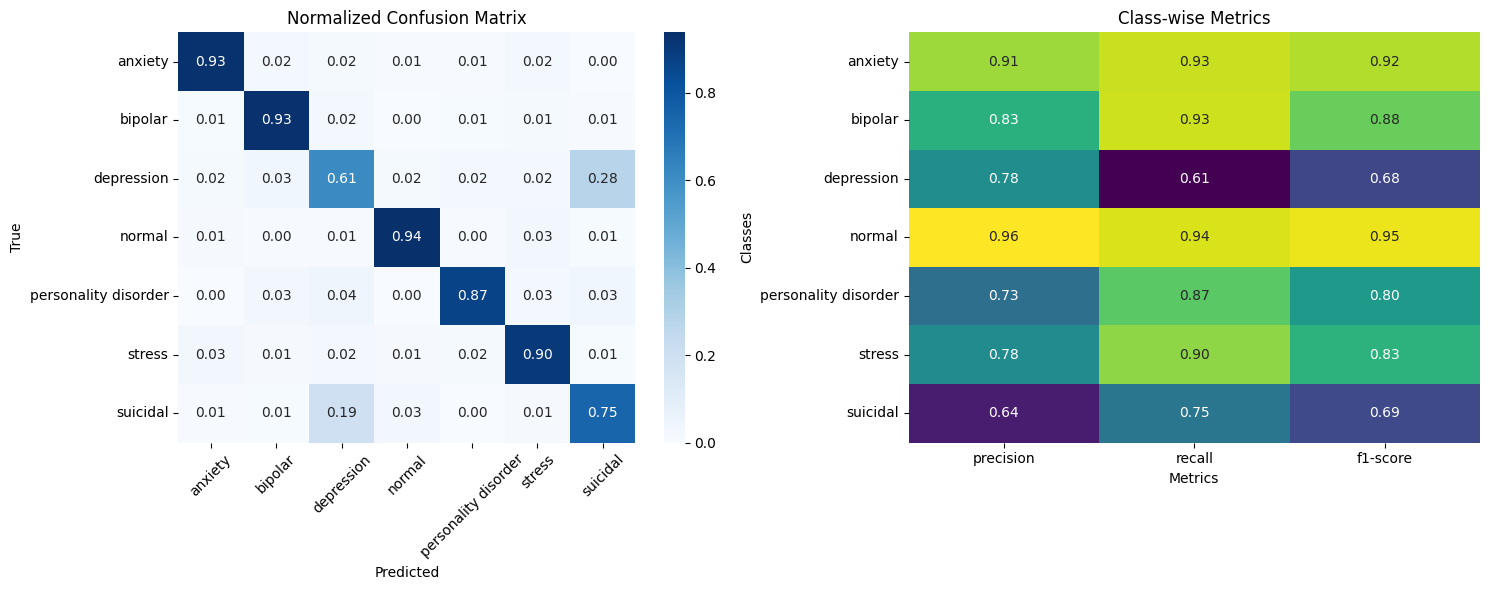

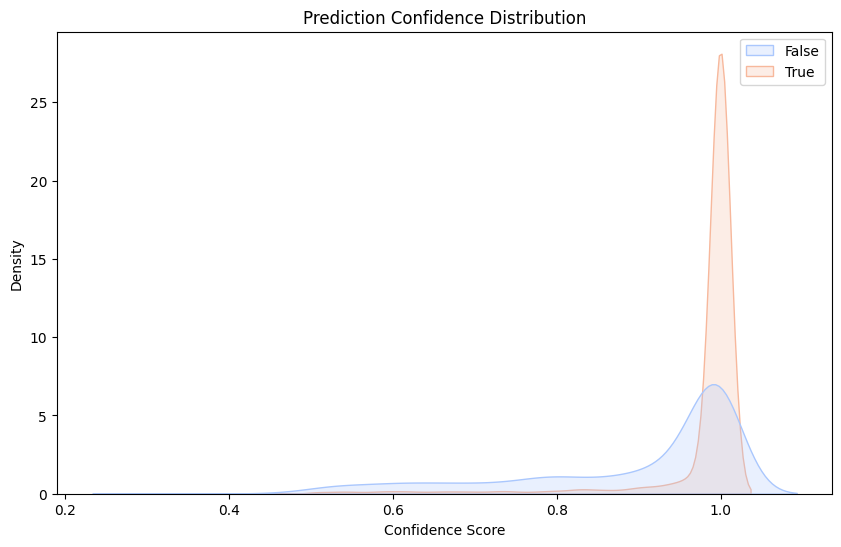

In [55]:
# Corrected TTA function with probabilities
def tta_predict(model, loader, n_aug=5):
    model.eval()
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for inputs, _ in loader:  # Modified to ignore labels
            if isinstance(inputs, tuple):
                inputs = inputs[0]
                
            inputs = inputs.to(DEVICE)
            outputs = torch.zeros((inputs.size(0), len(le.classes_)), device=DEVICE)
            
            for _ in range(n_aug):
                noise = torch.randn_like(inputs) * 0.05
                outputs += model(inputs + noise)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return all_preds, all_probs

# Updated visualization function
def visualize_performance(true_labels, predictions, probs, class_names):
    plt.figure(figsize=(15, 6))
    
    # 1. Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=12)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('True', fontsize=10)
    plt.xticks(rotation=45)
    
    # 2. Class-wise Metrics
    plt.subplot(1, 2, 2)
    report = classification_report(true_labels, predictions, 
                                  target_names=class_names, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    
    sns.heatmap(metrics_df[['precision', 'recall', 'f1-score']], 
                annot=True, cmap='viridis', fmt='.2f', cbar=False)
    plt.title('Class-wise Metrics', fontsize=12)
    plt.xlabel('Metrics', fontsize=10)
    plt.ylabel('Classes', fontsize=10)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

    # 3. Confidence Distribution
    plt.figure(figsize=(10, 6))
    correct = np.array(predictions) == np.array(true_labels)
    sns.kdeplot(x=np.max(probs, axis=1), hue=correct, 
                palette='coolwarm', fill=True, common_norm=False)
    plt.title('Prediction Confidence Distribution', fontsize=12)
    plt.xlabel('Confidence Score', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.show()

# Final evaluation
preds, probs = tta_predict(model, test_loader)
print("\nEnhanced Classification Report:")
print(classification_report(all_labels, preds, target_names=le.classes_))
visualize_performance(all_labels, preds, probs, le.classes_)